Initial implementation of https://arxiv.org/pdf/2410.10103

Attempting to reproduce Lorenz'96 analysis, with deep learning extension to learn the coordinate transforms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from kausal.generator import lorenz96
from kausal.koopman import *

# Causal Koopman

### Causal dependence with cumulative neighborhood shifts

We evaluate the spatial dependence. We attempt to reproduce Figures 7, 8 of the paper for Lorenz'96 dynamics.

In [3]:
# Integration
t0, t1 = 0.0, 10.0
dt = 0.001
steps = int((t1 - t0) / dt)

N = 101  # Number of sites / 'oscillators'
F = 4.0 
initial_state = F + torch.randn(N)

# Solve the system
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: lorenz96(t, state, params)

    solution = solver(
        dynamics,
        initial_state,
        t,
        method = 'dopri5',
        options = {'max_num_steps': 100000}
    )
    return t, solution

params = (F, )
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract results
omega = solution.T


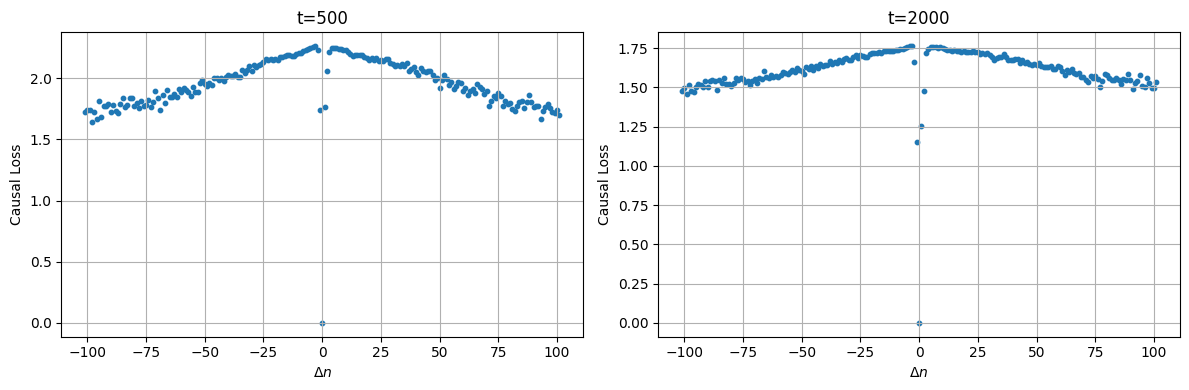

In [4]:
# Causal effect (cumulative neighborhood effect)
center_idx = 51
neighborhood_range = range(-N, N+1)
t_shifts = [500, 2000]

f, ax = plt.subplots(1, len(t_shifts), figsize=(12,4))

for i, t_shift in enumerate(t_shifts):
    
    ## Construct Effect
    effect = omega[center_idx : center_idx+1, :]

    ## Compute causal loss with varying neighborhood ranges
    causal_losses = []
    
    for delta_n in neighborhood_range:
        
        ## Construct Cause (cumulative neighborhood)
        if delta_n < 0:
            neighbor_indices = [(center_idx + i) % N for i in range(delta_n, 0)]
        
        else:
            neighbor_indices = [(center_idx + i) % N for i in range(1, delta_n + 1)]
    
        cause = omega[neighbor_indices, :]
        
        ## Compute causal loss
        causal_loss, _, _ = compute_causal_loss(
            cause = cause, 
            effect = effect, 
            t = t_shift
        )
        
        causal_losses.append(causal_loss)
    
    ## Plot
    ax[i].scatter(neighborhood_range, causal_losses, s=10)
    ax[i].set_title(f't={int(t_shift)}')
    ax[i].grid()
    ax[i].set_xlabel(r"$\Delta n$")
    ax[i].set_ylabel("Causal Loss")

plt.tight_layout()
plt.show();


100%|██████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.24it/s]


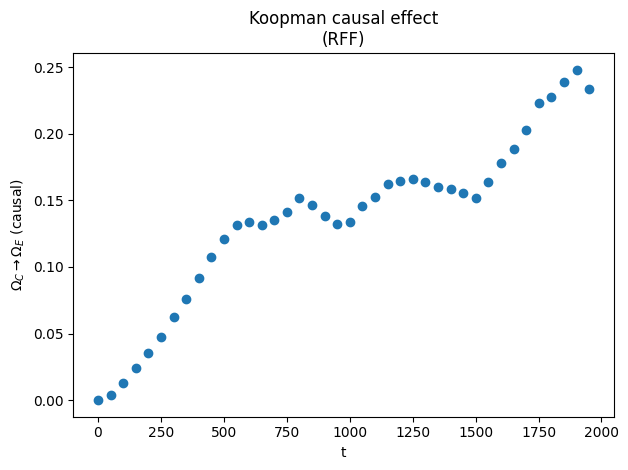

In [5]:
# Causal shifts
time_shifts = torch.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

cause = omega[center_idx-3:center_idx, :]
effect = omega[center_idx:center_idx+3, :]

for t in tqdm(time_shifts):
    
    ## 1. Causal loss
    causal_loss, _, _ = compute_causal_loss(
        cause = cause, 
        effect = effect,
        t = t
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.title('Koopman causal effect\n(RFF)')
plt.tight_layout()
plt.show();


# Deep Causal Koopman
Using neural network (encoder-decoder) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the observables.

In [6]:
from kausal.observables import MLPFeatures

In [7]:
# Hyperparameters
hidden_channels = [16, 32]
lr = 1e-2
epochs = 500

# Utility function
transform_1d = lambda x: x.permute(1, 0) # Transform into MLP-compatible shape of (T, C)


100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.25it/s]


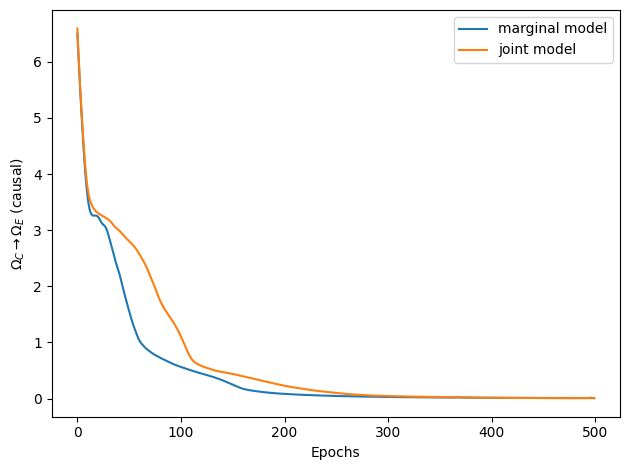

In [8]:
# 1. Causal direction
## Dataset prep
cause = transform_1d(omega[center_idx-3 : center_idx])
effect = transform_1d(omega[center_idx : center_idx+3])
effect_cause = torch.cat([effect, cause], axis=1)
n_train = int(0.8 * steps)

## Initialize models
marginal_model = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3)
joint_model = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3)

## Fit models
marginal_loss = marginal_model.fit(
    x = effect[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = n_train
)

joint_loss = joint_model.fit(
    x = effect_cause[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = n_train
)

## Plot loss
plt.plot(marginal_loss, label='marginal model')
plt.plot(joint_loss, label='joint model')
plt.xlabel('Epochs')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.legend()
plt.tight_layout()
plt.show();


100%|██████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 56.05it/s]


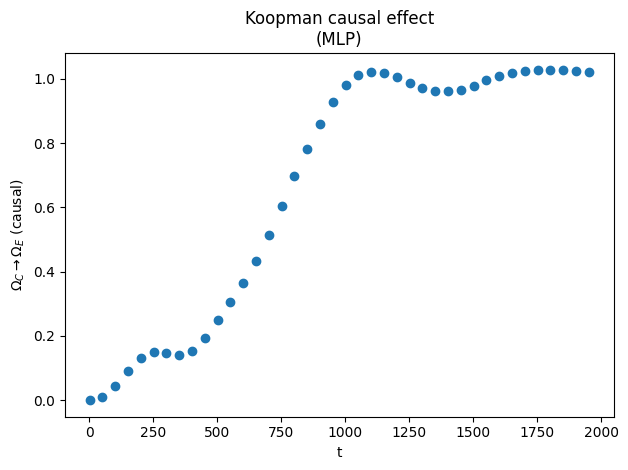

In [9]:
# Causal shifts
time_shifts = torch.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    with torch.no_grad():

        ## 1. Causal loss
        causal_loss, _, _ = compute_causal_loss(
            cause = omega[center_idx-3 : center_idx], 
            effect = omega[center_idx : center_idx+3],
            t = t,
            marginal_model = marginal_model,
            joint_model = joint_model
        )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.title('Koopman causal effect\n(MLP)')
plt.tight_layout()
plt.show();
